## Basics

In [1]:
def get_results_for_p(p,all_results):
    # Create the key as a tuple
    #key = (p.num_z,p.num_v,p.num_n,p.n_bar,p.num_q,p.q_0,p.prod_q,p.hire_c,p.k_entry,p.k_f,p.prod_alpha,p.dt)
    key = (p.num_z,p.num_v,p.num_n,p.n_bar,p.num_q,p.q_0,p.prod_q,p.hire_c,p.prod_alpha,p.dt,p.u_bf_m)
    # Check if the key exists in the saved results
    if key in all_results:
        print(key)
        return all_results[key]
    else:
        print(f"No results found for p = {key}")
        return None

from primitives import Parameters
p = Parameters()
import pickle
import matplotlib.pyplot as plt
import numpy as np
from plots import Plots
import cProfile
import pstats

plts=Plots(p)
cc_J,cc_W,cc_Wstar,cc_Jpi,cc_pc,mwc_J,mwc_W,mwc_Wstar,mwc_pc,mwc_n1,mwc_s_J,mwc_s_W,mwc_s_Wstar,mwc_s_sep,mwc_sd_J,mwc_sd_W,mwc_sd_Wstar,mwc_sd_sep=None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None

In [2]:
# Load the temp objects
try:
    with open('my_objects.pkl', 'rb') as file:
        objects = pickle.load(file)
except FileNotFoundError:
    # If the file doesn't exist, start with an empty dictionary
    objects = {}

# Load the permanent results, for sep, across different parametrizations
with open("results_Rho_sep.pkl", "rb") as file:
    all_results = pickle.load(file)
results = get_results_for_p(p,all_results)

No results found for p = (3, 200, 5, 4, 1, 1.0, 1.0, 5.0, 0.5, 0.25, 1.0)


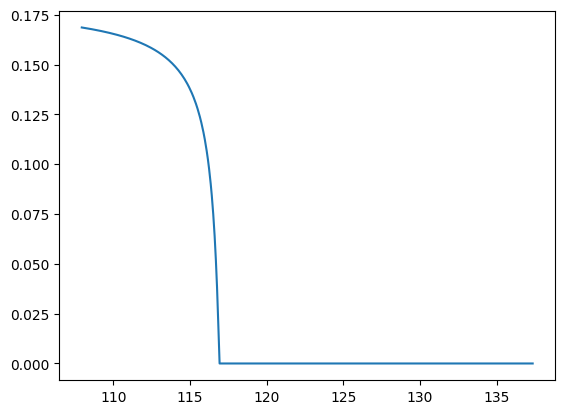

In [3]:
from ContinuousContract import ContinuousContract
cc=ContinuousContract(p)
(cc_J,cc_W,cc_Wstar,cc_Jpi,cc_pc)=cc.J(1)

So the shapes are the same, it's just the domains that are quite different...
Is that the issue? That the value the worker earns at the current firm and the set of admissible promised value from OJS are v different?
Gotta dig deeper into how the search function is approximated methinks

Update 24/10/24: My intuition now is that it's indeed the v_0/sign-on wage that are the issue. Basic v_0 is both way too large and weird economically.
However, setting v_0=U has so far been problematic, somehow v_0 eclipses the entire v_grid, even the very top, so that the sign-on wage is positive.

Making the v_grid custom, aka the same as the W... didn't help at all, and also just doesn't seem like a good idea. As long as the v_0 is ok, using v_grid should be fine

In [4]:
from Multiworker_Contract_GE import MultiworkerContract
mwc_GE=MultiworkerContract(p)

J shape (3, 5, 5, 200, 1)
W shape (3, 5, 5, 200, 1, 2)
Slow kappa method
kappa 8.26060659208359
signon [0.         0.00981266 0.01969233 0.02963945 0.03965449 0.04973792
 0.05989019 0.07011178 0.08040317 0.09076482 0.10119722 0.11170086
 0.12227621 0.13292377 0.14364404 0.1544375  0.16530465 0.17624601
 0.18726208 0.19835336 0.20952037 0.22076364 0.23208367 0.24348099
 0.25495613 0.26650963 0.27814201 0.28985382 0.30164559 0.31351788
 0.32547124 0.33750621 0.34962335 0.36182323 0.37410641 0.38647346
 0.39892495 0.41146146 0.42408357 0.43679186 0.44958692 0.46246935
 0.47543974 0.48849869 0.50164681 0.5148847  0.52821298 0.54163226
 0.55514317 0.56874633 0.58244237 0.59623193 0.61011565 0.62409416
 0.63816812 0.65233817 0.66660498 0.6809692  0.69543149 0.70999254
 0.72465301 0.73941358 0.75427493 0.76923776 0.78430275 0.7994706
 0.81474202 0.83011772 0.8455984  0.86118478 0.87687758 0.89267753
 0.90858537 0.92460182 0.94072763 0.95696355 0.97331033 0.98976872
 1.00633949 1.0230234  1.03

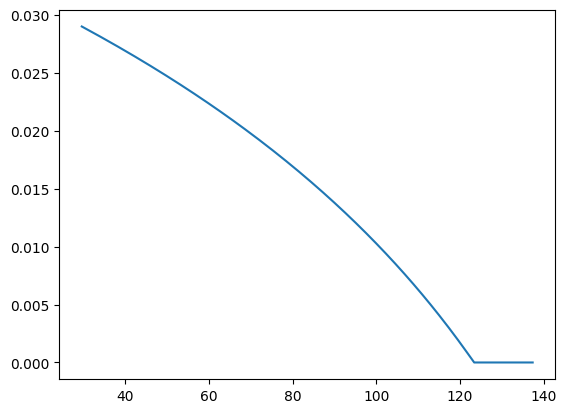

n0_star borders 0.0 3.7782036981188893
Diff Rho: 12.499505207331687
EJinv -85.71782540575771
EJderiv -28.181233901843683
EJinv diff 1j 2s: 2.302019102005082
EJinv diff 1 sen: 43.359770954115945
EJinv diff 2 sen: 2.7950162918103754
n0_star borders 0.0 2.2920004706046395
Diff Rho: 31.072362582828884
EJinv -62.17295897405636
EJderiv -37.109725079327404
EJinv diff 1j 2s: 1.7976271706926026
EJinv diff 1 sen: 6.104774201548552
EJinv diff 2 sen: 0.26280803577180384
n0_star borders 0.0 1.7466270837128188
Diff Rho: 10.598813410823944
EJinv -47.595268868509024
EJderiv -42.8008676849789
EJinv diff 1j 2s: 5.11727509205245
EJinv diff 1 sen: 0.8236608478862856
EJinv diff 2 sen: 0.6440726752857334
n0_star borders 0.0 2.0800154956548567
Diff Rho: 11.039838087048363
EJinv -39.31756003124887
EJderiv -47.372879136448375
EJinv diff 1j 2s: 8.63807523326297
EJinv diff 1 sen: 1.5173494886586654
EJinv diff 2 sen: 0.8510242951570354
n0_star borders 0.0 2.0
Diff Rho: 21.02947165103482
EJinv -35.39647050099933
E

c:\Users\andre\Codes\Multi-worker firm\Multiworker_wage_2steps\primitives.py:184: RuntimeWarning: invalid value encountered in power
  return np.power( np.power(self.p.alpha/q,self.p.sigma) - np.power(self.p.alpha,self.p.sigma), 1 / self.p.sigma )


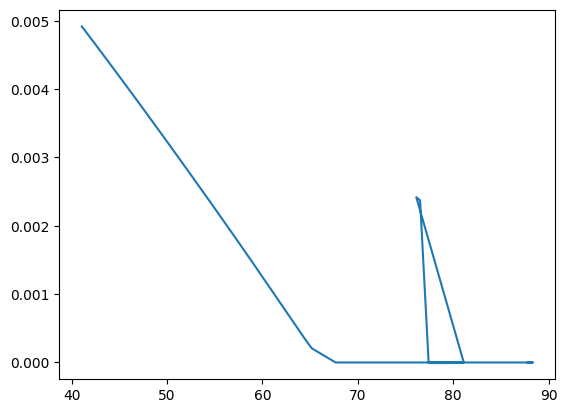

EJinv -81.28318964126909
EJderiv -64.22607082693493
EJinv diff 1j 2s: 0.429386456636846
EJinv diff 1 sen: 2.913360880202242
EJinv diff 2 sen: 0.23981895962140992
n0_star borders 0.0 1.3656110226001497
Diff Rho: 4.923576562372328
EJinv -80.56364067250068
EJderiv -77.25128987555094
EJinv diff 1j 2s: 0.17397943098188487
EJinv diff 1 sen: 0.09012303204800266
EJinv diff 2 sen: 0.027595861816496505
n0_star borders 0.0 1.3616048033549975
Diff Rho: 7.430274372589482
EJinv -80.5535847931133
EJderiv -77.0204707595919
EJinv diff 1j 2s: 0.17771459610335746
EJinv diff 1 sen: 0.009736802205654186
EJinv diff 2 sen: 0.007949761439673306
n0_star borders 0.0 1.3587722836656613
Diff Rho: 6.306744774202865
EJinv -80.54522066084921
EJderiv -76.86048058470865
EJinv diff 1j 2s: 0.1818093001589132
EJinv diff 1 sen: 0.009520847834877744
EJinv diff 2 sen: 0.00813309200377892
n0_star borders 0.0 1.3564073005589439
Diff Rho: 5.70483987763554
EJinv -80.53041850053457
EJderiv -76.74231688038657
EJinv diff 1j 2s: 0.

c:\Users\andre\Codes\Multi-worker firm\Multiworker_wage_2steps\Multiworker_Contract_GE.py:1084: RuntimeWarning: divide by zero encountered in divide
  q=np.minimum(self.p.hire_c/(kappa-signon_bonus),1)


n0_star borders 0.0 1.5006696480767037
Diff Rho: 5.301560478836792
EJinv -79.03541248115268
EJderiv -74.25596162556782
EJinv diff 1j 2s: 0.21434827947519636
EJinv diff 1 sen: 0.030583003900942145
EJinv diff 2 sen: 0.007280613476866269
n0_star borders 0.0 1.4935884598288691
Diff Rho: 3.3891402381980864
EJinv -79.00611056037486
EJderiv -74.21739643892789
EJinv diff 1j 2s: 0.21479996105733098
EJinv diff 1 sen: 0.02984820307556987
EJinv diff 2 sen: 0.005355241359189775
n0_star borders 0.0 1.4875539074121034
Diff Rho: 4.226128492712928
EJinv -78.97657485503773
EJderiv -74.17927589134744
EJinv diff 1j 2s: 0.21538495447144332
EJinv diff 1 sen: 0.011482018418721358
EJinv diff 2 sen: 0.005315696115693751
n0_star borders 0.0 1.4824651243371285
Diff Rho: 3.515522482321863
EJinv -78.94666129819116
EJderiv -74.14159697788247
EJinv diff 1j 2s: 0.21575082031979106
EJinv diff 1 sen: 0.011583056790392385
EJinv diff 2 sen: 0.004397040851292603
n0_star borders 0.0 1.4782271598909176
Diff Rho: 3.376862667

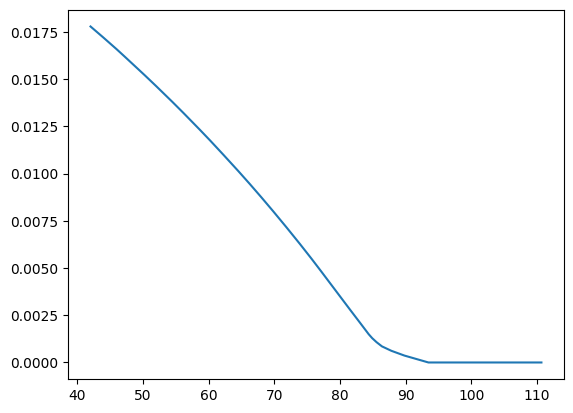

EJinv -33.28338961478482
EJderiv -22.786672324734397
EJinv diff 1j 2s: 0.3219125997894235
EJinv diff 1 sen: 0.9512827951674876
EJinv diff 2 sen: 1.1270553801125693
n0_star borders 0.0 2.0248484999649694
Diff Rho: 0.32328710170006747
EJinv -32.64083602577647
EJderiv -22.19477920598814
EJinv diff 1j 2s: 0.3122579803141132
EJinv diff 1 sen: 0.7572602649219278
EJinv diff 2 sen: 2.5289681661640806
n0_star borders 0.0 2.0247887730070397
Diff Rho: 0.3231305279333323
EJinv -32.0387826109265
EJderiv -22.55917248732912
EJinv diff 1j 2s: 0.291554164145877
EJinv diff 1 sen: 0.6450813546556593
EJinv diff 2 sen: 1.1332174528150882
n0_star borders 0.0 2.024205053432835
Diff Rho: 0.3224469697064407
EJinv -31.54298101049877
EJderiv -22.876400239993558
EJinv diff 1j 2s: 0.28217366446343467
EJinv diff 1 sen: 0.6255488780530742
EJinv diff 2 sen: 0.8322676460696368
n0_star borders 0.0 2.023211054758975
Diff Rho: 0.3217729238448502
EJinv -31.12737634682515
EJderiv -22.154916045954934
EJinv diff 1j 2s: 0.268

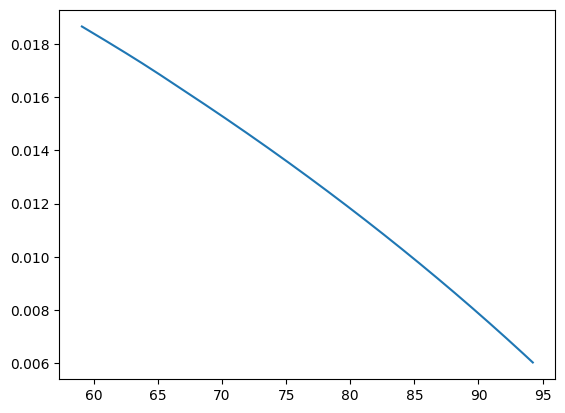

EJinv -16.008607768877464
EJderiv -12.3043408442161
EJinv diff 1j 2s: 0.29905130926962015
EJinv diff 1 sen: 0.44180607918702236
EJinv diff 2 sen: 0.653841891903885
n0_star borders 0.0 2.191459433530807
Diff Rho: 0.15550150336062207
EJinv -15.986287518169382
EJderiv -12.225289989154618
EJinv diff 1j 2s: 1.0576303656799388
EJinv diff 1 sen: 0.44106011654684013
EJinv diff 2 sen: 0.8274386364013218
n0_star borders 0.0 2.19192657162395
Diff Rho: 0.15525677830340248
EJinv -15.986453269145782
EJderiv -12.342046420297962
EJinv diff 1j 2s: 0.42769772337316453
EJinv diff 1 sen: 0.452751942703446
EJinv diff 2 sen: 0.45215282746539476
n0_star borders 0.0 2.1921159824234997
Diff Rho: 0.15500339586607786
EJinv -15.987064429258842
EJderiv -12.44177420922712
EJinv diff 1j 2s: 1.672324948600218
EJinv diff 1 sen: 0.46339576300963375
EJinv diff 2 sen: 0.40392933462389524
n0_star borders 0.0 2.192107822497627
Diff Rho: 0.15474209712604303
EJinv -15.985906581891719
EJderiv -12.527884371773268
EJinv diff 1j

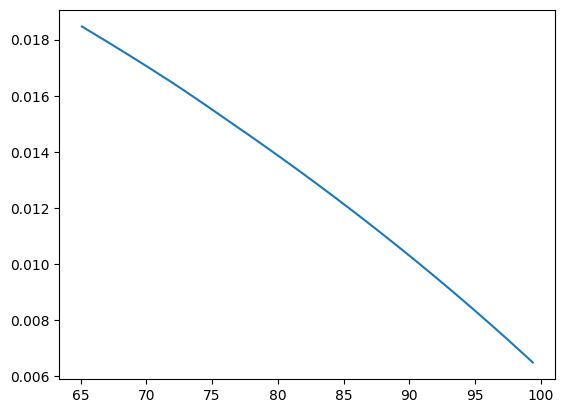

EJinv -13.152580008390995
EJderiv -8.598092400557448
EJinv diff 1j 2s: 0.729962653310258
EJinv diff 1 sen: 0.41318835221815337
EJinv diff 2 sen: 0.44398870676644736
n0_star borders 0.0 2.3248353867418365
Diff Rho: 0.06992417127919785
EJinv -13.165716798900426
EJderiv -8.569283776175197
EJinv diff 1j 2s: 0.6550813208636077
EJinv diff 1 sen: 0.634569769827039
EJinv diff 2 sen: 0.4548873900638597
n0_star borders 0.0 2.3249497814543156
Diff Rho: 0.06979105082738492
EJinv -13.185754291711813
EJderiv -8.617918651733248
EJinv diff 1j 2s: 0.6487183539716197
EJinv diff 1 sen: 0.5399090139364191
EJinv diff 2 sen: 0.49664281705169516
n0_star borders 0.0 2.324917375283821
Diff Rho: 0.06965573635854577
EJinv -13.202412600819533
EJderiv -8.65959412314757
EJinv diff 1j 2s: 0.7409689546150452
EJinv diff 1 sen: 0.5011493064036608
EJinv diff 2 sen: 0.5571632138188595
n0_star borders 0.0 2.324788425946565
Diff Rho: 0.06951834458471823
EJinv -13.216112309877483
EJderiv -8.69569467638371
EJinv diff 1j 2s: 

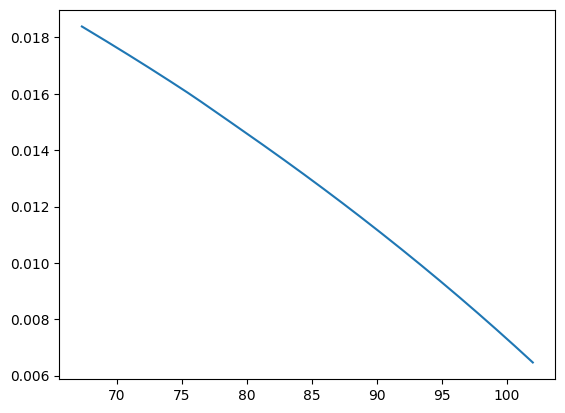

EJinv -12.750555098581692
EJderiv -7.849934622106943
EJinv diff 1j 2s: 1.1551276300436615
EJinv diff 1 sen: 0.5050138009931114
EJinv diff 2 sen: 0.7144843009411039
n0_star borders 0.0 2.3923759921538723
Diff Rho: 0.030866242493970544
EJinv -12.749645672240442
EJderiv -7.835459137536688
EJinv diff 1j 2s: 1.1562024647723936
EJinv diff 1 sen: 0.5347113245250801
EJinv diff 2 sen: 1.0386742635561848
n0_star borders 0.0 2.392513701682939
Diff Rho: 0.030808390145400207
EJinv -12.752884276874815
EJderiv -7.8575896762935145
EJinv diff 1j 2s: 1.140190826885818
EJinv diff 1 sen: 0.6542061044115549
EJinv diff 2 sen: 3.2703064968546376
n0_star borders 0.0 2.392555730069266
Diff Rho: 0.030753071459292687
EJinv -12.755649594058605
EJderiv -7.876395773780644
EJinv diff 1j 2s: 1.1434891846117854
EJinv diff 1 sen: 0.5911686598230591
EJinv diff 2 sen: 0.884364845928086
n0_star borders 0.0 2.3925332059324695
Diff Rho: 0.030696508240449994
EJinv -12.75795889955471
EJderiv -7.892540749484155
EJinv diff 1j 2

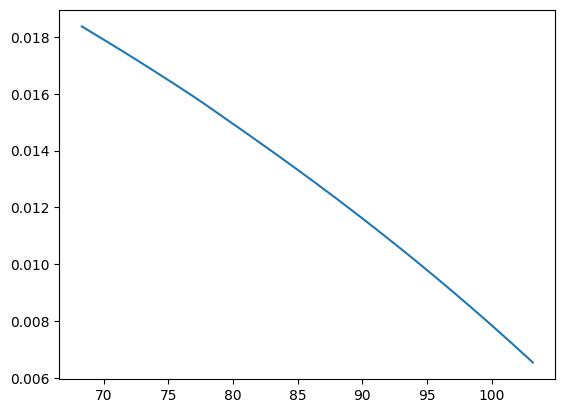

EJinv -12.592248336379665
EJderiv -7.721698930938047
EJinv diff 1j 2s: 2.025731114726639
EJinv diff 1 sen: 0.4944581427760366
EJinv diff 2 sen: 0.46871854486577547
n0_star borders 0.0 2.4207866282252377
Diff Rho: 0.015756708575817395
EJinv -12.591814354910376
EJderiv -7.7124014785564015
EJinv diff 1j 2s: 2.9164752144903896
EJinv diff 1 sen: 0.48604091032410696
EJinv diff 2 sen: 0.5018796774331651
n0_star borders 0.0 2.420897272494762
Diff Rho: 0.015736724420367065
EJinv -12.593834587991235
EJderiv -7.72493521707608
EJinv diff 1j 2s: 1.9645560553479617
EJinv diff 1 sen: 0.48457290125476127
EJinv diff 2 sen: 0.5877577685167673
n0_star borders 0.0 2.4209399783111234
Diff Rho: 0.015718203794753645
EJinv -12.595578339919296
EJderiv -7.73548600479225
EJinv diff 1j 2s: 1.6325835340136086
EJinv diff 1 sen: 0.49075629498571677
EJinv diff 2 sen: 0.8249607178063101
n0_star borders 0.0 2.4209359065085208
Diff Rho: 0.015698025248227283
EJinv -12.597054529108238
EJderiv -7.744450205174502
EJinv diff

In [5]:
# GE basic
#mwc_GE_J = objects['mwc_GE_J']
#mwc_GE_W = objects['mwc_GE_W']
mwc_GE_J = objects['mwc_GE_J']
mwc_GE_W = objects['mwc_GE_W']

(mwc_GE_J,mwc_GE_W,mwc_GE_Wstar,mwc_GE_sep,mwc_GE_n0,mwc_GE_n1)=mwc_GE.J(None,None,1)

objects['mwc_GE_J'] = mwc_GE_J
objects['mwc_GE_W'] = mwc_GE_W
 
with open('my_objects.pkl', 'wb') as file:
    pickle.dump(objects, file)

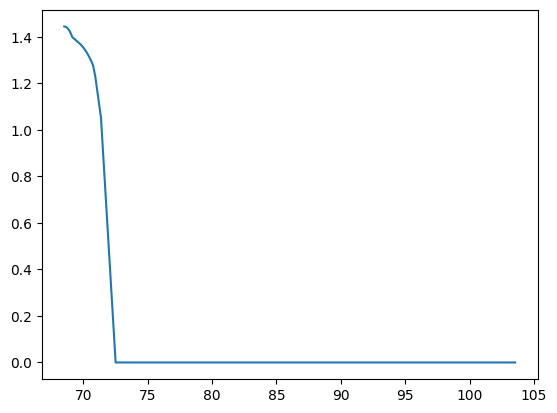

In [6]:
prod = p.z_0-0
j=0
s=1
#plt.plot(mwc_W[p.z_0-1,0,1,:,1],mwc_J[p.z_0-1,0,1,:])
#plt.plot(mwc.w_grid,mwc_n0[p.z_0,0,0,:])
#plt.plot(mwc.w_grid,mwc_W[p.z_0,0,1,:,1])
#plt.plot(mwc_W[p.z_0,0,1,:,1],mwc_n0[p.z_0,0,1,:])
#plt.plot(mwc_W[p.z_0-1,1,1,:,1],mwc_n0[p.z_0-1,1,1,:])
#plt.plot(mwc_Rho_W[p.z_0,0,0,:,5,1],mwc_Rho_n0[p.z_0,0,0,:,5])
plt.plot(mwc_GE_W[prod,j,s,:,0,1],mwc_GE_n0[prod,j,s,:,0])
#plt.plot(mwc_Rho_s_W[prod,j,s,:,0,1],mwc_Rho_s_n0[prod,j,s,:,0])


#Something is very wrong here, for some reason, when the seniors are the "cheapest" (lowest w_grid), the firm doesn't hire???
#Also the top part is still...kinda weird
#Also no hiring at 1 junior, but hiring at 1 senior???

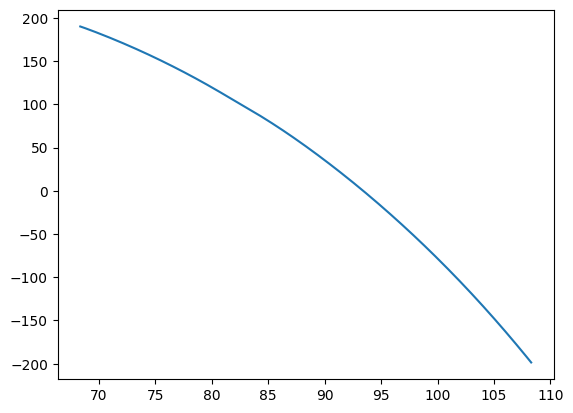

In [8]:
prod = p.z_0-2
j=0
s=3
maxv= 135
#plt.plot(mwc_W[p.z_0,j,s,:,1],mwc_J[p.z_0,j,s,:])
#plt.plot(mwc_hmq_W[p.z_0,j,s,:,0,1],mwc_hmq_J[p.z_0,j,s,:,0]-mwc_hmq_J[p.z_0,j-1,s,:,0])
#plt.plot(mwc_Rho_W[p.z_0,j,s,:,0,1],mwc_Rho_J[p.z_0,j,s,:,0]-mwc_Rho_J[p.z_0,j-1,s,:,0])
plt.plot(mwc_GE_W[prod,j,s,:,0,1],mwc_GE_J[prod,j,s,:,0])
#plt.plot(mwc_Rho_s_W[prod,j,s,:,0,1],mwc_Rho_s_J[prod,j,s,:,0])

#plt.plot(mwc_Rho.w_grid,mwc_Rho_J[prod,j,s,:,0])
#plt.plot(mwc_hmq_W[prod,j,s,:,0,1],mwc_hmq_J[prod,j,s,:,0])
#plt.plot(mwc_Rho_W[p.z_0,j,s,:,0,1],mwc_Rho_n1[p.z_0,j,s,:,0])

In [6]:
from Multiworker_Contract_hire_Rho import MultiworkerContract
mwc_Rho=MultiworkerContract(p,cc.js)

In [ ]:
mwc_Rho_J = objects['mwc_Rho_J']
mwc_Rho_W = objects['mwc_Rho_W']

profiler = cProfile.Profile()
profiler.enable()
(mwc_Rho_J,mwc_Rho_W,mwc_Rho_Rho,mwc_Rho_Wstar,mwc_Rho_pc,mwc_Rho_n0,mwc_Rho_n1)=mwc_Rho.J()
profiler.disable()
# Print profiling results
stats = pstats.Stats(profiler).sort_stats(pstats.SortKey.TIME)
#stats.print_stats()

objects['mwc_Rho_J'] = mwc_Rho_J
objects['mwc_Rho_W'] = mwc_Rho_W
with open('my_objects.pkl', 'wb') as file:
    pickle.dump(objects, file)

In [ ]:
if results is None:
    mwc_Rho_s_J = objects['mwc_Rho_s_J']
    mwc_Rho_s_W = objects['mwc_Rho_s_W']
else:
    mwc_Rho_s_J = results['J']
    mwc_Rho_s_W = results['W']

(mwc_Rho_s_J,mwc_Rho_s_W,mwc_Rho_s_Rho,mwc_Rho_s_Wstar,mwc_Rho_s_sep,mwc_Rho_s_n0,mwc_Rho_s_n1)=mwc_Rho.J_sep_dir(mwc_Rho_J,mwc_Rho_W)

objects['mwc_Rho_s_J'] = mwc_Rho_s_J
objects['mwc_Rho_s_W'] = mwc_Rho_s_W
with open('my_objects.pkl', 'wb') as file:
    pickle.dump(objects, file)

In [ ]:
from Multiworker_Contract_all import MultiworkerContract
K=2 #number of tenure levels
mwc=MultiworkerContract(p,cc.js)
(mwc_J,mwc_W,mwc_Wstar,mwc_pc,mwc_n0,mwc_n1)=mwc.J()

In [ ]:
# GE separations
if results is None:
    mwc_GE_s_J = objects['mwc_GE_J']
    mwc_GE_s_W = objects['mwc_GE_W']
else:
    mwc_GE_s_J = results['Ji']
    mwc_GE_s_W = results['W1i']

(mwc_GE_s_J,mwc_GE_s_W,mwc_GE_s_Wstar,mwc_GE_s_sep,mwc_GE_s_n0,mwc_GE_s_n1)=mwc_GE.J_sep_dir(mwc_GE_J,mwc_GE_W,1)

objects['mwc_GE_s_J'] = mwc_GE_s_J
objects['mwc_GE_s_W'] = mwc_GE_s_W
 
with open('my_objects.pkl', 'wb') as file:
    pickle.dump(objects, file)

# Plots

In [15]:
output_dir = 'Plots'
if not os.path.exists(output_dir):
         os.makedirs(output_dir)

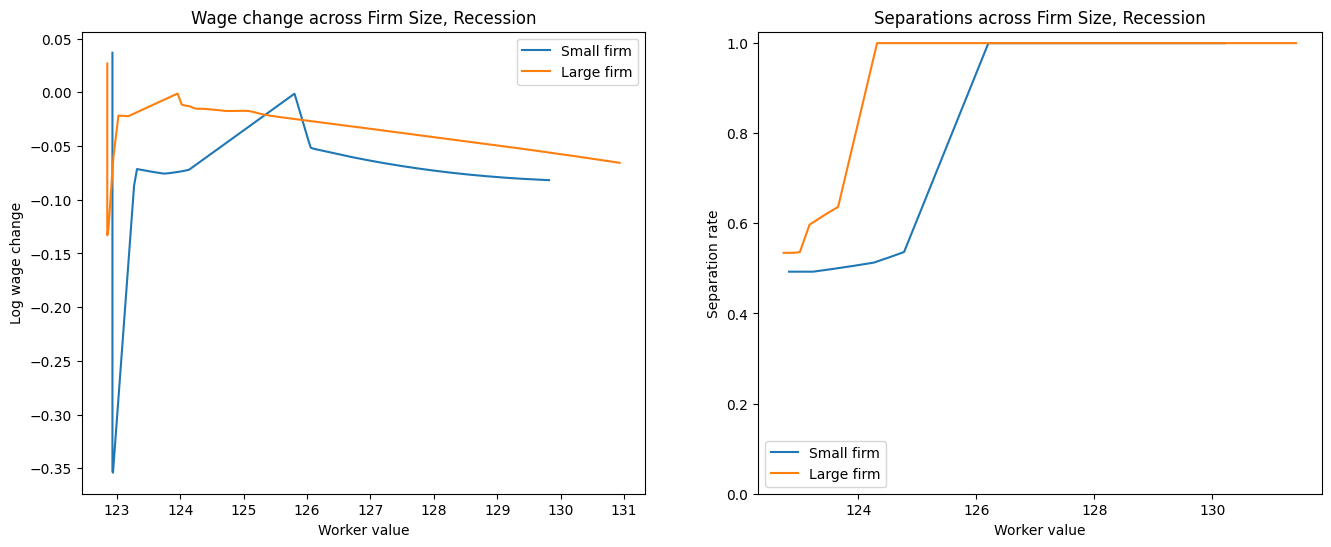

In [16]:
        #THIS IS SOMEHOW THE OPPOSITE??? In firms with many juniors wage drops are larger?? Why?? I guess they don't care for that many seniors?
        #But then why would it equialize afterwards... AHHH BECAUSE ALL THE JUNIORS ARE ALREADY FIRED
        #Now 1,3 places much higher weight on its expensive seniors hencewhy wage drop not that large...? WAGE DROP BOUNCES UP A BIT WHEN THEY START FIRING
        #Still can't understand why 1,1 goes for full firing earlier tho... Also at the same time that complete firing happens, wage drops amplify... guess that makes sense tho
        save=1
        plt.figure(figsize=(16, 6))  # Width=16 inches, Height=6 inches

        # First subplot
        plt.subplot(1, 2, 1) 
        # Plot the data
        #plt.plot(mwc_Rho_s_W[0, 1, 1 ,:, 5, 1], mwc_Rho_s_Wstar[0, 1, 1 ,:, 5]-mwc_Rho_s_W[0, 1, 1 ,:, 5, 1], label='Small firm')
        plt.plot(mwc_Rho_s_Wstar[0, 1, 1 ,:, 5], np.log(np.interp(mwc_Rho_s_Wstar[0, 1, 1 ,:, 5],mwc_Rho_s_W[0,1,1,:,5,1],mwc_Rho.w_grid))-np.log(mwc_Rho.w_grid), label='Small firm')
        plt.plot(mwc_Rho_s_Wstar[0, 1, 3 ,:, 5], np.log(np.interp(mwc_Rho_s_Wstar[0, 1, 3 ,:, 5],mwc_Rho_s_W[0,1,3,:,5,1],mwc_Rho.w_grid))-np.log(mwc_Rho.w_grid), label='Large firm')

        #plt.plot(mwc_Rho_s_W[0, 1, 3 ,:, 5, 1], mwc_Rho_s_Wstar[0, 1, 3 ,:, 5]-mwc_Rho_s_W[0, 1, 3 ,:, 5, 1], label='Larger firm')
        #plt.plot(baseline_W[0, 3, 1 ,:, 5, 1], baseline_Wstar[0, 3, 1 ,:, 5]-baseline_W[0, 3, 1 ,:, 5, 1], label='Larger firm wage')
        #if mwc_s_W is not None:
        #    plt.plot(mwc_s_W[p.z_0-1, 0, 1,:, 1], mwc_s_Wstar[p.z_0-1, 0, 1, :]-mwc_s_W[p.z_0-1, 0, 1,:, 1], label='DRS with separations')
        #if mwc_s_dir_W is not None:
        #    plt.plot(mwc_s_dir_W[p.z_0-1, 0, 1,:, 1], mwc_s_dir_Wstar[p.z_0-1, 0, 1, :]-mwc_s_dir_W[p.z_0-1, 0, 1,:, 1], label='DRS with direct separations')
        plt.legend()
        # Add titles and labels
        plt.title('Wage change across Firm Size, Recession')
        plt.xlabel('Worker value')
        plt.ylabel('Log wage change')

        # Secone subplot
        plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot

        plt.plot(mwc_Rho_s_W[0, 1, 1, :, 0 ,1], mwc_Rho_s_sep[0, 1, 1, :, 0], label='Small firm')
        plt.plot(mwc_Rho_s_W[0, 1, 3, :, 0 ,1], mwc_Rho_s_sep[0, 1, 3, :, 0], label='Large firm')

        plt.legend()
        # Add titles and labels
        plt.title('Separations across Firm Size, Recession')
        plt.xlabel('Worker value')
        plt.ylabel('Separation rate')
        plt.ylim(ymin=0)
        if save==1:
          plt.savefig(os.path.join(output_dir,'Log wage cuts and Separations Across Size.png'), bbox_inches='tight')  # Save as PNG

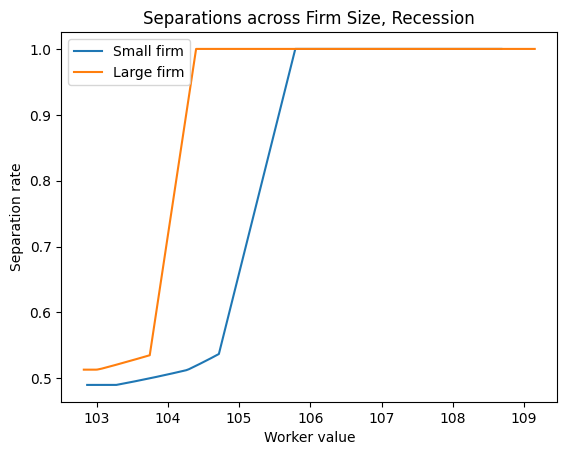

In [28]:

if save==1:
        plt.savefig(os.path.join(output_dir,'Separations Across Size.png'), bbox_inches='tight')  # Save as PNG

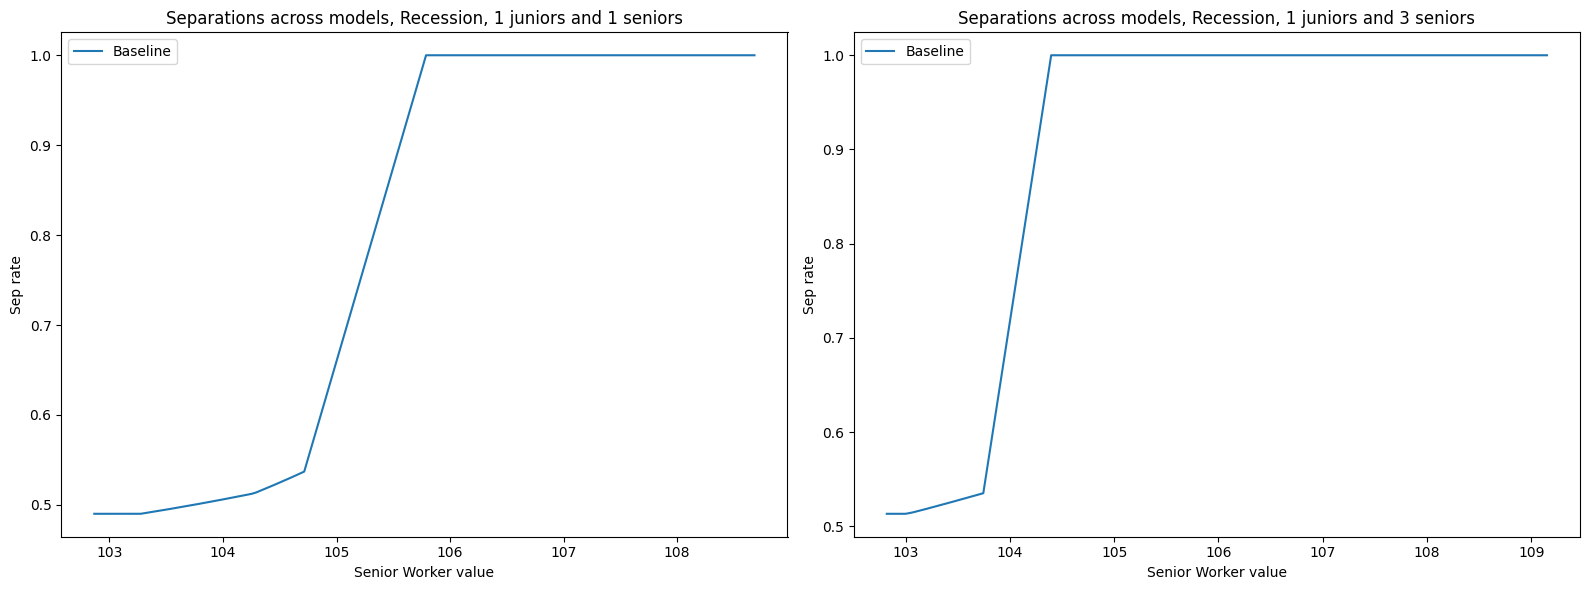

In [14]:
plot_sep(0,0,    1,1,    1,3,    0,  0,0,    0)

In [11]:
def plot_sep(prod1,prod2,jun1,sen1,jun2,sen2,qual,minwage=0,hiresub=0, save=0):       
 
        plt.figure(figsize=(16, 6))  # Width=16 inches, Height=6 inches

        # First subplot
        plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
        prod=prod1
        jun=jun1
        sen=sen1

        #plt.plot(mwc_GE_s_W[prod1, jun, sen, :, qual ,1], mwc_GE_s_sep[prod1, jun, sen, :, qual], label='Baseline')
        plt.plot(mwc_Rho_s_W[prod1, jun, sen, :, qual ,1], mwc_Rho_s_sep[prod1, jun, sen, :, qual], label='Baseline')

     

        if prod1 == 2:
          plt.title(f'Separations across models, Boom, {jun} juniors and {sen} seniors')
        elif prod1 == 0:
          plt.title(f'Separations across models, Recession, {jun} juniors and {sen} seniors')
        else:
          plt.title(f'Separations across models, {prod} productivity, {jun} juniors and {sen} seniors')
        plt.xlabel('Senior Worker value')
        plt.ylabel('Sep rate')
        plt.legend()
        # Second subplot
        plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
        prod=prod2
        jun=jun2
        sen=sen2

        #plt.plot(mwc_GE_s_W[prod2, jun, sen, :, qual ,1], mwc_GE_s_sep[prod2, jun, sen, :, qual], label='Baseline')
        plt.plot(mwc_Rho_s_W[prod2, jun, sen, :, qual ,1], mwc_Rho_s_sep[prod2, jun, sen, :, qual], label='Baseline')
        # Adjust layout to prevent overlap
        if prod2 == 2:
          plt.title(f'Separations across models, Boom, {jun} juniors and {sen} seniors')
        elif prod2 == 0:
          plt.title(f'Separations across models, Recession, {jun} juniors and {sen} seniors')
        else:
          plt.title(f'Separations across models, {prod} productivity, {jun} juniors and {sen} seniors')
        plt.xlabel('Senior Worker value')
        plt.ylabel('Sep rate')
        plt.legend()       
        
        plt.tight_layout()

        if save==1:
          plt.savefig(os.path.join(output_dir,'Separations main 2.png'), bbox_inches='tight')  # Save as PNG

        # Show the plot (optional)
        plt.show()

In [7]:
names = [ 'DRS HMQ', 'DRS HMQ via RHO', 'HMQ']

In [ ]:
plts.CRSvsDRSvalue(names,cc_W,cc_J,mwc_hmq_W[...,0,:],mwc_Rho_J[...,0],mwc_Rho_W[...,0,:],mwc_Rho_J[...,0],None,None,0)

In [9]:
def plot_GE(prod1,prod2,jun1,sen1,jun2,sen2,qual,minwage=0,hiresub=0, save=0):       
 
        plt.figure(figsize=(16, 6))  # Width=16 inches, Height=6 inches

        # First subplot
        plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
        prod=prod1
        jun=jun1
        sen=sen1
       
        plt.plot(mwc_GE_W[prod1, jun, sen, :, qual ,1], mwc_GE_J[prod1, jun, sen, :, qual], label='Baseline')
        if mwc_GE_s_W is not None:
          plt.plot(mwc_GE_s_W[prod1, jun, sen, :, qual ,1], mwc_GE_s_J[prod1, jun, sen, :, qual], label='With separations')


     

        if prod1 == 2:
          plt.title(f'Firm Value, Boom, {jun} juniors and {sen} seniors')
        elif prod1 == 0:
          plt.title(f'Firm Value, Recession, {jun} juniors and {sen} seniors')
        else:
          plt.title(f'Firm Value, {prod} productivity, {jun} juniors and {sen} seniors')
        plt.xlabel('Senior Worker value')
        plt.ylabel('Firm Value')
        plt.legend()
        # Second subplot
        plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
        prod=prod2
        jun=jun2
        sen=sen2
        plt.plot(mwc_GE_W[prod2, jun, sen, :, qual ,1], mwc_GE_J[prod2, jun, sen, :, qual], label='Baseline')
        if mwc_GE_s_W is not None:
          plt.plot(mwc_GE_s_W[prod2, jun, sen, :, qual ,1], mwc_GE_s_J[prod2, jun, sen, :, qual], label='With separations')

       
        # Adjust layout to prevent overlap
        if prod2 == 2:
          plt.title(f'Firm Value, Boom, {jun} juniors and {sen} seniors')
        elif prod2 == 0:
          plt.title(f'Firm Value, Recession, {jun} juniors and {sen} seniors')
        else:
          plt.title(f'Firm Value, {prod} productivity, {jun} juniors and {sen} seniors')
        plt.xlabel('Senior Worker value')
        plt.ylabel('Firm Value')
        plt.legend()       
        
        plt.tight_layout()

        if save==1:
          plt.savefig(os.path.join(output_dir,'General Equilibrium Value Function.png'), bbox_inches='tight')  # Save as PNG

        # Show the plot (optional)
        plt.show()

In [ ]:
plot_GE(2,0,    1,2,    1,1,    0,  0,0,    0)

In [6]:
baseline_sep = objects['baseline_sep']
baseline_W = objects['baseline_W']
baseline_Wstar = objects['baseline_Wstar']


noHMQ_sep = objects['noHMQ_sep']
noHMQ_W = objects['noHMQ_W']
noHMQ_Wstar = objects['noHMQ_Wstar']
nohire_sep = objects['nohire_sep']
nohire_W = objects['nohire_W']
nohire_Wstar = objects['nohire_W']
hiresub_sep = objects['hiresub_sep']
hiresub_W = objects['hiresub_W']
hiresub_Wstar = objects['hiresub_Wstar']

In [7]:
import os
output_dir = 'Plots'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [8]:
def plott(prod1,prod2,jun1,sen1,jun2,sen2,qual,minwage=0,hiresub=0, save=0):       
 
        plt.figure(figsize=(16, 6))  # Width=16 inches, Height=6 inches

        # First subplot
        plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
        prod=prod1
        jun=jun1
        sen=sen1
        if baseline_W is not None:        
            plt.plot(baseline_W[prod1, jun, sen, 5:50, qual ,1], baseline_sep[prod1, jun, sen, 5:50, qual], label='Baseline')
        plt.plot(mwc_hmq_sd_W[prod1, jun, sen, 5:50, qual ,1], mwc_hmq_sd_sep[prod1, jun, sen, 5:50, qual], label='New baseline')
        if nohire_W is not None:        
         plt.plot(nohire_W[prod1, jun, sen, 5:50, qual ,1], nohire_sep[prod1, jun, sen, 5:50, qual], label='CRS') #Not true CRS but still
        #if noHMQ_W is not None:        
        # plt.plot(noHMQ_W[prod1, jun, sen, 5:50, qual, 1], noHMQ_sep[prod1, jun, sen, 5:50, qual], label='No match heterog')
        #if minwage_W is not None: 
        # if minwage ==1: 
        #  plt.plot(minwage_W[prod1, jun, sen, 5:50, qual, 1], minwage_sep[prod1, jun, sen, 5:50, qual], label='Min wage')
        if hiresub ==1 :
          plt.plot(hiresub_W[prod1, jun, sen, 5:50, qual, 1], hiresub_sep[prod1, jun, sen, 5:50, qual], label='Hiring subsidy')

     

        if prod1 == 2:
          plt.title(f'Separations across models, Boom, {jun} juniors and {sen} seniors')
        elif prod1 == 0:
          plt.title(f'Separations across models, Recession, {jun} juniors and {sen} seniors')
        else:
          plt.title(f'Separations across models, {prod} productivity, {jun} juniors and {sen} seniors')
        plt.xlabel('Senior Worker value')
        plt.ylabel('Sep rate')
        plt.legend()
        # Second subplot
        plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
        prod=prod2
        jun=jun2
        sen=sen2
        if baseline_W is not None:        
            plt.plot(baseline_W[prod2, jun, sen, 5:50, qual, 1], baseline_sep[prod2, jun, sen, 5:50, qual], label='Baseline')
        plt.plot(mwc_hmq_sd_W[prod2, jun, sen, 5:50, qual ,1], mwc_hmq_sd_sep[prod2, jun, sen, 5:50, qual], label='New baseline')
        if nohire_W is not None:        
         plt.plot(nohire_W[prod2, jun, sen, 5:50, qual, 1], nohire_sep[prod2, jun, sen, 5:50, qual], label='CRS')  
        #if noHMQ_W is not None:        
        # plt.plot(noHMQ_W[prod2, jun, sen, 5:50, qual, 1], noHMQ_sep[prod2, jun, sen, 5:50, qual], label='No match heterog')     
        #if minwage_W is not None:
        # if minwage == 1:  
        #  plt.plot(minwage_W[prod2, jun, sen, 5:50, qual, 1], minwage_sep[prod2, jun, sen, 5:50, qual], label='Min wage')
        if hiresub ==1 :
          plt.plot(hiresub_W[prod2, jun, sen, 5:50, qual, 1], hiresub_sep[prod2, jun, sen, 5:50, qual], label='Hiring subsidy')            
        # Adjust layout to prevent overlap
        if prod2 == 2:
          plt.title(f'Separations across models, Boom, {jun} juniors and {sen} seniors')
        elif prod2 == 0:
          plt.title(f'Separations across models, Recession, {jun} juniors and {sen} seniors')
        else:
          plt.title(f'Separations across models, {prod} productivity, {jun} juniors and {sen} seniors')
        plt.xlabel('Senior Worker value')
        plt.ylabel('Sep rate')
        plt.legend()       
        
        plt.tight_layout()

        if save==1:
          plt.savefig(os.path.join(output_dir,'Separations main 2.png'), bbox_inches='tight')  # Save as PNG

        # Show the plot (optional)
        plt.show()

In [ ]:
plott(0,0,  1,3,    2,2,    5,0,0,save=0)

In [ ]:
plott(0,0,  1,1,    1,3,    5, 0,0, save=0)

In [ ]:
        prod2=0
        save=1
        qual = 5
        if baseline_W is not None:        
            plt.plot(baseline_W[prod2, 1, 1, 5:, qual, 1], baseline_sep[prod2, 1, 1, 5:, qual], label='Small firm')
        if baseline_W is not None:        
            plt.plot(baseline_W[prod2, 1, 3, 5:, qual, 1], baseline_sep[prod2, 1, 3, 5:, qual], label='Larger firm')  
        #if baseline_W is not None:        
        
        #plt.plot(baseline_W[prod2, 1, 3, 5:, qual, 1], baseline_sep[prod2, 1, 3, 5:, qual], label='Many seniors')     
         
        # Adjust layout to prevent overlap
        if prod2 == 2:
          plt.title(f'Separations across size, Boom')
        elif prod2 == 0:
          plt.title(f'Separations across size, Recession')
        else:
          plt.title(f'Separations across size, {prod} productivity')
        plt.xlabel('Senior Worker value')
        plt.ylabel('Sep rate')
        plt.legend()       
        
        plt.tight_layout()

        if save==1:
          plt.savefig(os.path.join(output_dir,'Separations across size new.png'), bbox_inches='tight')  # Save as PNG

        # Show the plot (optional)
        plt.show()

In [ ]:
#This is no DRS/hiring. Even less firing than no HMQ

plts.sep(0,p.z_0,1,3,1,3,None,None,noHMQ_W[...,1,:],noHMQ_sep[...,1])

In [ ]:
plts.CRSvsDRSpolicy(cc_W,cc_Wstar,baseline_W[...,0,:],baseline_Wstar[...,0],nohire_W[...,0,:],baseline_Wstar[...,0],None,None,0)

In [ ]:
plts.CRSvsDRSdirect(cc_J,mwc_J,0)

In [ ]:
plts.CRSvsDRSsurplus(cc_J,cc_W,mwc_J,mwc_W,0)

In [ ]:
import matplotlib.pyplot as plt
import os
# Create a directory to save plots
output_dir = 'Plots'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [ ]:
            #something like: sep_star = interp(0,foc_sep,sep_grid) + extra conditions
            #need derivatives of future expectations!
            # for that, I interpolate onto rho_star,n0_star, and one of n1_s/q_s. If I'm looking for derivative wrt size, I interpolate onto q_s and THEN take the difference between two discrete values
            #n1_s[iz,in0,in1,iv,iq,s] = (N_grid[in0]*(1-sep_grid[s])+N_grid1[in1]) * pc_temp[iz,in0,in1,iv] #Gives me sep for every damn value hell yeah
            #n1_s_ceil = np.ceil(np.interp( n1_s, N_grid1, range(self.p.num_n))).astype(int)
            #n1_s_floor = np.floor(np.interp( n1_s, N_grid1, range(self.p.num_n))).astype(int)
            #J_n1[iz,...,s,in11] = RegularGridInterpolator((N_grid, rho_grid, Q_grid), EJpi[iz, :, in11, ...], bounds_error=False, fill_value=None) ((n0_star[iz, ...], rho_star[iz, ...], q_s[iz, ...,s]))
            #J_fut_deriv_n[...,s] = (J_n1[...,s,n1_s_ceil[...,s]] - J_n1[...,s,n1_s_floor[...,s]] ) / (N_grid1[n1_s_ceil[...,s]] - N_grid1[n1_s_floor[...,s]]) #This may need a proper loop
            # Boundary check: first_bound = (n1_s_ceil==0), last_bound = (N_grid1[n1_s_floor]==n_bar)
            #J_fut_deriv_n[first_bound] = (J_n1[first_bound,1] - J_n1[first_bound,0] ) / (N_grid1[1] - N_grid1[0])
            #J_fut_deriv_n[last_bound] = (J_n1[last_bound,-1] - J_n1[last_bound,-2] ) / (N_grid1[-1] - N_grid1[-2])
 
            #q_s = (N_grid[self.grid[1]] * (self.p.q_0 - np.max(sep_grid[s]-( 1- self.p.q_0),0))+Q_grid[self.grid[4]]*N_grid1[self.grid[2]]) / (N_grid[self.grid[1]]*(1-sep_grid[s])+N_grid1[self.grid[2]])
            #J_q[iz,...,s,iqq] = RegularGridInterpolator((N_grid, N_grid1, rho_grid), EJpi[iz, ..., iqq], bounds_error=False, fill_value=None) ((n0_star[iz, ...], n1_s[iz,...,s], rho_star[iz, ...]))
            #J_fut_deriv_q[...,s] = (J_q[...,s,q_s_ceil[...,s]] - J_n1  [...,s,q_s_floor[...,s]] ) / (Q_grid[q_s_ceil[...,s]] - Q_grid[q_s_floor[...,s]]) #This may need a proper loop
            # Boundary check: first_bound = (q_s_ceil==0), last_bound = (Q_grid[q_s_floor]=1.0)
            #J_fut_deriv_q[first_bound] = (J_q[first_bound,1] - J_q[first_bound,0] ) / (Q_grid1[1] - Q_grid1[0])
            #J_fut_deriv_q[last_bound] = (J_q[last_bound,-1] - J_q[last_bound,-2] ) / (Q_grid1[-1] - Q_grid1[-2])
            #q_deriv_s = N_grid[grid[1]] * q_s / (N_grid1[grid[2]]+(1-sep_grid[s])*N_grid[grid[1]]) #Probably need to loop over s. Not efficient, but simpler than redoing the whole self.grid thing
            #worker_fut_value = interp ( rho_star,rho_grid,re+EW1i)                    #This is because we don't yet have the worker future value yet. OR just use EW1_star and re_star??? a little risky but possible.
            #Could be a good start
            #foc_sep[...,s] = - J_fut_deriv[...,s] * pc_temp + J_fut_deriv_q * q_deriv_s - (re+EW1i - EUi) / self.pref.inv_utility_1d(self.v_0-self.p.beta*(s_grid[s] * EUi + (1-s_grid[s]) * (EW1_star + re_star)
            # sep_neg = np.all (foc <= 0, axis = -1)
            # sep_max = np.all (foc > 0, axis = -1)
            # sep_star[sep_neg] = 0
            # sep_star[sep_max] = 1.0 #OH SHIT WHAT IF THE Q IS ALREADY AT ITS MAX? I think this should account for it, no?
            #sep_star = interp_multidim(0,-impose_decreasing(foc_sep),sep_grid) 